# $ \nabla_\theta\log\pi_\theta(a_t\ |\ s_t)G_t $
  
# $ \nabla_\theta\log\pi_\theta(a_t\ |\ s_t)\ R_t $

# $ \nabla_\theta\log\pi_\theta(a_t\ |\ s_t)\ \sum_{t=0}^{\infty} r_t $

# $ \nabla_\theta\log\pi_\theta(a_t\ |\ s_t)\ \sum_{t'=t}^{\infty} r_{t'} $ 
#### for $\nabla_\theta\log\pi_\theta(a_t\ |\ s_t)$
  
# $ \nabla_\theta\log\pi_\theta(a_t\ |\ s_t)\ (\sum_{t'=t}^{\infty} r_{t'} - b(s_t)) $ 
  
# $ \nabla_\theta\log\pi_\theta(a_t\ |\ s_t)\ (\sum_{t'=t}^{\infty} r_{t'} - V(s_t))$
  
# $ \frac{1}{2} \left \|(V(s_t) - \sum_{t'=t}^{\infty} r_{t'})\right \|^{2} $

# $ V(s_{t}) = r_t + \gamma V(s_{t+1}) $
  
# $ A(s_t, a_t) = r_t + \gamma V(s_{t+1}) - V(s_{t})$

# $ loss = \frac{1}{2} \left \|(V(s_t) - \delta)\right \|^{2} $

# $ \nabla_\theta\log\pi_\theta(a_t\ |\ s_t)\ A(s_t, a_t)$

# $ \left\|R(s_t, a_t) - V(s_t)\right\|^{2} - \log\pi_\theta(a_t\ |\ s_t)\ (R(s_t, a_t) - V(s_t)) - \beta H(\pi(s_t))$
  
  
  
# $ 1 + \gamma V(s') $  
  
# $ 1 + \gamma1 + \gamma^{2} V(s') $  
  
# $ 1 + \gamma1 + \gamma^{2}1 + \gamma^{3} V(s') $  
  
# $ \sum_{i=0}^{k-1} \gamma^ir_{t+i} + \gamma^{k}V(s_{t+k}) - V(s_t) $
  
  
# Testing

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import gym as gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
import cv2 as cv2
import random
import tensorflow.contrib.eager as tfe
import tensorflow as tf
tf.enable_eager_execution()
%matplotlib inline

from utils.plotting import RewardHistory


/home/william/anaconda3/envs/dev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Actor Critic with a model

In [2]:
# import tensorflow.contrib.eager as tfe

class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.dense2 = tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)

    def call(self, inputs):
        result = inputs
        result = self.dense1(inputs)
        result = self.dense2(result)
        return result
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
        loss = y * tf.cast(targets, dtype="float32")
        loss = tf.reduce_sum(loss, reduction_indices=1)
#         print(loss.shape)
        loss = tf.log(loss)
        return loss

    def grad(self, inputs, targets, reward):
        with tfe.GradientTape() as tape:
            loss_value = - tf.reduce_mean(self.loss(inputs, targets) * reward)
        return tape.gradient(loss_value, self.variables)
    
    def train(self, optimizer, inputs, targets, reward):
        grads = self.grad(inputs, targets, reward)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    
model = LinearModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

reward = tf.constant([5., 5., 5.])
reward = tf.expand_dims(reward, axis=1)
print("reward:", reward)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 10

for epoch in range(num_epochs):

#     y = tf.constant([[0], [1]], dtype="int32")
    y = tf.one_hot([0, 1, 1], depth=2, dtype="int32")
#     y = tf.constant([1, 0, 1], dtype="int32")

    # Optimize the model
    grads = model.grad(batch, y, reward)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())
        
model(batch)

batch: tf.Tensor(
[[0.12689304 0.17796123 0.9247192  0.18005943]
 [0.43751323 0.08991969 0.5182879  0.23770607]
 [0.9738157  0.24305856 0.46452355 0.17282498]], shape=(3, 4), dtype=float32)
reward: tf.Tensor(
[[5.]
 [5.]
 [5.]], shape=(3, 1), dtype=float32)
result: tf.Tensor(
[[0.5015548  0.4984452 ]
 [0.47823742 0.52176255]
 [0.45190695 0.5480931 ]], shape=(3, 2), dtype=float32)


<tf.Tensor: id=946, shape=(3, 2), dtype=float32, numpy=
array([[0.8410551 , 0.1589449 ],
       [0.2507103 , 0.74928975],
       [0.03161556, 0.96838444]], dtype=float32)>

In [3]:
# import tensorflow.contrib.eager as tfe

class ValueModel(tf.keras.Model):
    def __init__(self):
        super(ValueModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.dense2 = tf.keras.layers.Dense(units=1)

    def call(self, inputs):
        result = self.dense1(inputs)
        result = self.dense2(result)
#         result = self.dense2(inputs)
        return result
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
        loss = tf.losses.mean_squared_error(targets, y)/2.
#         loss = tf.squared_difference(targets, y)
        return loss

    def grad(self, inputs, targets):
        with tfe.GradientTape() as tape:
            loss_value = self.loss(inputs, targets)
        return tape.gradient(loss_value, self.variables)
    
    def train(self, optimizer, inputs, targets):
        grads = self.grad(inputs, targets)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    

model = ValueModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 50

for epoch in range(num_epochs):

    y = tf.expand_dims(tf.constant([5, 5, 5], dtype=tf.float32), axis=1)

    # Optimize the model
    model.train(optimizer, batch, y)
    
        
model(batch)

batch: tf.Tensor(
[[0.42226422 0.5987942  0.5428134  0.71957433]
 [0.20376611 0.45345533 0.45331442 0.04149389]
 [0.03896058 0.27375734 0.7311944  0.9693494 ]], shape=(3, 4), dtype=float32)
result: tf.Tensor(
[[-0.2877614 ]
 [-0.09891583]
 [-0.35045716]], shape=(3, 1), dtype=float32)


<tf.Tensor: id=6955, shape=(3, 1), dtype=float32, numpy=
array([[5.2839084],
       [4.2131414],
       [4.6942825]], dtype=float32)>

# Simple Memory

In [76]:
Transition = namedtuple("Transition", ["s", "a", "s1", "r", "done"])

class PolicyGradientMemory():
    def __init__(self, gamma = 0.9):
        self.memory = []
        self.gamma = gamma
    
    def reset(self):
        self.memory = []
    
    def append(self, transition):
        self.memory.append(transition)
        
    
    def sample(self):
        batched = Transition(*zip(*self.memory))
        s = np.array(list(batched.s))
        a = np.array(list(batched.a))
        s1 = np.array(list(batched.s1))
        r = np.array(list(batched.r), dtype="float32")
        done = np.array(list(batched.done))
        
#         reward = 0.
#         for i in reversed(range(len(r))):
#             moving_reward = self.gamma * reward
#             reward = r[i] + moving_reward
#             r[i] = reward
#         print(r)
        r = np.expand_dims(r, axis=1)
        return [s, a, s1, r, done]
    
    def __len__(self):
        return len(self.memory)
    
    def __str__(self):
        result = []
        for i in range(self.__len__()):
            result.append(self.memory[i].__str__() + " \n")
        return "".join(result)

memory = PolicyGradientMemory()

memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1, True))
memory.append(Transition([1, 2, 3], 0, [4, 5, 6], 1, False))
memory.append(Transition([1, 2, 3], 0, [4, 5, 6], 1, False))
memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1, False))
memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1, False))


# print(memory)
a = memory.sample()
print("s:", a[0])
print("a:", a[1])
print("s1:", a[2])
print("r:", a[3])
print("done:", a[4])




s: [[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]
a: [1 0 0 1 1]
s1: [[4 5 6]
 [4 5 6]
 [4 5 6]
 [4 5 6]
 [4 5 6]]
r: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
done: [ True False False False False]


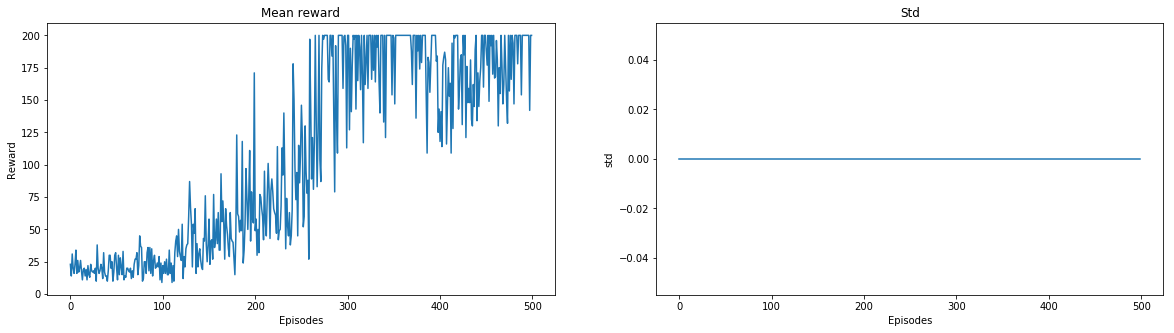

In [67]:
class Agent():
    def __init__(self, env=gym.make('CartPole-v0')):
        self.env = env
        self.episode_durations = []
        self.episode_loss = []
        self.gamma = 0.99
        self.model = LinearModel()
        self.value_model = ValueModel()
        self.memory = PolicyGradientMemory(gamma=self.gamma)
        self.action_optimizer = tf.train.AdamOptimizer(learning_rate=0.002)
        self.value_optimizer = tf.train.AdamOptimizer(learning_rate=0.002)
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s], dtype=tf.float32)
        action_probability = self.model(s).numpy()
        action = np.random.choice([0, 1], p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        for i in range(episodes):
            s = self.env.reset()
            episode_reward = 0
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                memory_done = done
                # Cartpole specific as the 200 step shouldn't really be done from a calculation perspective
                if self.env.spec.id == "CartPole-v0" and memory_done and episode_reward >= 199:  
                    memory_done = False
                self.memory.append(Transition(s, action, s_1, reward, memory_done))
                
                s = s_1
                
                episode_reward += reward
                if done:
                    break

                    
            self.episode_durations.append(episode_reward)
                    
            s0, a, s1, r, done = self.memory.sample()
            s0 = tf.constant(s0, dtype=tf.float32)
            a = tf.one_hot(a, depth=2, dtype=tf.int32)
            s1 = tf.constant(s1, dtype=tf.float32)
            r = tf.constant(r, dtype=tf.float32)
            d = tf.expand_dims(tf.constant(1 - done, dtype=tf.float32), axis=1)

            v = self.value_model(s0)
            v_prime = self.value_model(s1)
#             q = r + self.gamma * d * v_prime
            Adv = r - v

            self.value_model.train(self.value_optimizer, s0, r)
            self.model.train(self.action_optimizer, s0, a, Adv)

            self.memory.reset()
            
    
    def run(self, env=gym.make('CartPole-v0')):
        self.env = env
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

agent = Agent()

reward_history = RewardHistory()
for i in range(1):
    agent = Agent()
    agent.train(500)
    reward_history.append(agent.episode_durations)

reward_history.plot()

# Mean return over 100 runs
- Actor Critic batched
![mean reward](./images/actor_critic_batch.png)

In [230]:
agent.run()

Episode finished successfully after 200 timesteps


# Combined model

In [101]:
# import tensorflow.contrib.eager as tfe

class CombinedModel(tf.keras.Model):
    def __init__(self, learning_rate=0.01, nb_actions=2):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)
        
        self.dense_v0 = tf.keras.layers.Dense(units=8, activation=tf.nn.relu)
        self.dense_v = tf.keras.layers.Dense(units=1)
        
        self.dense_p0 = tf.keras.layers.Dense(units=8, activation=tf.nn.relu)
        self.dense_p = tf.keras.layers.Dense(units=nb_actions, activation=tf.nn.softmax)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    def call(self, state):
        v = self.V(state)
        p = self.P(state)
        return p, v

    def V(self, state):
        value = self.dense1(state)
        value = self.dense_v0(value)
        value = self.dense_v(value)
        return value
    
    def P(self, state):
        policy = state
        policy = self.dense1(policy)
        policy = self.dense_p0(policy)
        policy = self.dense_p(policy)
        return policy

    def v_train(self, state, targets):
        with tfe.GradientTape() as tape:
            y = self.V(state)
            loss = tf.losses.mean_squared_error(targets, y)
            loss_value = tf.reduce_mean(loss)
        grads = tape.gradient(loss_value, self.variables)
        self.optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())

    def p_train(self, state, action, advantage):
        with tfe.GradientTape() as tape:
            y = self.P(state)
            # entropy of action prob, entropy increases when prob dist is more diverse
            # gradient ascent will encourage diverse prob dist
#             entropy = -tf.reduce_sum(y * tf.log(y))
            
            loss = y * tf.cast(action, dtype="float32")
            loss = tf.reduce_sum(loss, reduction_indices=1)
            loss = tf.log(loss)
            loss_value = - tf.reduce_mean(loss * advantage) #- 0.01 * entropy
        grads = tape.gradient(loss_value, self.variables)
        self.optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    
    def train(self, state, action, Rt):
        with tfe.GradientTape() as tape:
            value = self.V(state)
            value_loss = tf.losses.mean_squared_error(Rt, value)
            
            action_prob = self.P(state)
            advantage = Rt - value
            action_loss = action_prob * tf.cast(action, dtype="float32")
            action_loss = tf.reduce_sum(action_loss, reduction_indices=1)
            action_loss = -tf.log(action_loss) * advantage
            action_loss = tf.reduce_mean(action_loss)
            
            # entropy of action prob, entropy increases when prob dist is more diverse
            # gradient ascent will encourage diverse prob dist
            entropy = -tf.reduce_mean(action_prob * tf.log(action_prob))
            
            loss_value = 0.5*value_loss + action_loss #- 0.01 * entropy
            
        grads = tape.gradient(loss_value, self.variables)
        self.optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    

model = CombinedModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

result = model.V(batch)
print("result:", result)

reward = tf.constant([5., 5., 5.])
reward = tf.expand_dims(reward, axis=1)
print("reward:", reward)

num_epochs = 50

for epoch in range(num_epochs):
    actions = tf.one_hot([0, 1, 1], depth=2, dtype="int32")
    y_v = tf.expand_dims(tf.constant([15, 15, 15], dtype="int32"), axis=1)

    # Optimize the model
    model.v_train(batch, y_v)
    model.p_train(batch, actions, reward)
    
        
print("V:", model.V(batch))
print("P:", model.P(batch))

batch: tf.Tensor(
[[0.7086438  0.76389086 0.2748611  0.5604025 ]
 [0.01238823 0.88400936 0.31704056 0.49385035]
 [0.05771804 0.49746907 0.6977955  0.08797717]], shape=(3, 4), dtype=float32)
result: tf.Tensor(
[[-0.08638135]
 [-0.08005769]
 [-0.03214703]], shape=(3, 1), dtype=float32)
reward: tf.Tensor(
[[5.]
 [5.]
 [5.]], shape=(3, 1), dtype=float32)
V: tf.Tensor(
[[15.616048]
 [14.092997]
 [12.935827]], shape=(3, 1), dtype=float32)
P: tf.Tensor(
[[0.9924637  0.00753632]
 [0.00373547 0.9962645 ]
 [0.00253214 0.9974679 ]], shape=(3, 2), dtype=float32)


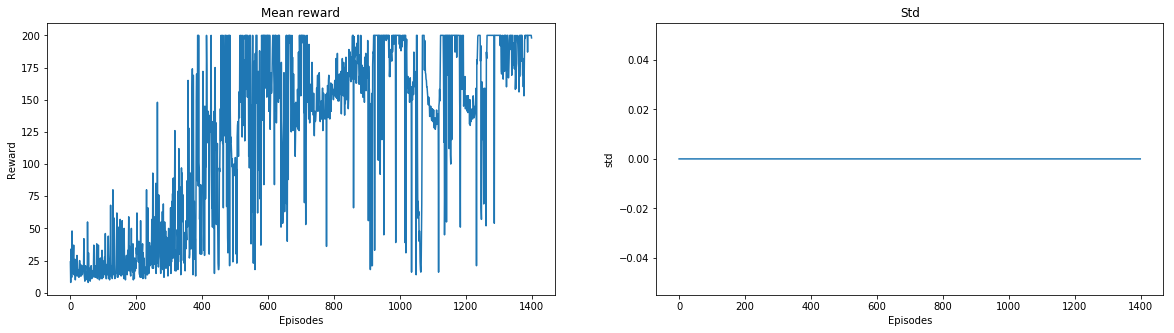

In [114]:
class Agent():
    def __init__(self, env=gym.make('CartPole-v0')):
        self.env = env
        self.episode_durations = []
        self.episode_loss = []
        self.gamma = 0.99
        self.model = CombinedModel(learning_rate=0.005, nb_actions=env.action_space.n)
        self.memory = PolicyGradientMemory(gamma=self.gamma)
        self.nb_actions = self.env.action_space.n
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s], dtype=tf.float32)
        action_probability = self.model.P(s).numpy()
        action = np.random.choice(np.arange(self.nb_actions), p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        for i in range(episodes):
            s = self.env.reset()
            episode_reward = 0
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                
                memory_done = done
                # Cartpole specific as the 200 step shouldn't really be done from a calculation perspective
                if self.env.spec.id == "CartPole-v0" and memory_done and episode_reward >= 199:  
                    memory_done = False
                self.memory.append(Transition(s, action, s_1, reward, memory_done))
                
                s = s_1
                
                episode_reward += reward
                if done:
                    break
                    
            self.episode_durations.append(episode_reward)
            
            # start training
            s0, a, s1, r, done = self.memory.sample()
            s0 = tf.constant(s0, dtype=tf.float32)
            a = tf.one_hot(a, depth=self.nb_actions, dtype=tf.int32)
            s1 = tf.constant(s1, dtype=tf.float32)
            r = tf.constant(r, dtype=tf.float32)
            d = tf.expand_dims(tf.constant(1 - done, dtype=tf.float32), axis=1)

            v = self.model.V(s0)
            v_prime = self.model.V(s1)
            r = r + self.gamma * d * v_prime
            Adv = r - v

#             self.model.v_train(s0, r)
#             self.model.p_train(s0, a, Adv)
            
            self.model.train(s0, a, r)
#             self.model.train(s0, a, r)

            self.memory.reset()
            

    
    def run(self, env=gym.make('CartPole-v0')):
        self.env = env
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

env=gym.make('CartPole-v0')
# env=gym.make('LunarLander-v2')
# agent = Agent(env)

reward_history = RewardHistory()
for i in range(1):
    agent = Agent(env)
    agent.train(1400)
    reward_history.append(agent.episode_durations)

reward_history.plot()

In [38]:
agent.run(env)


# A2C

In [28]:
# import tensorflow.contrib.eager as tfe

class A2CModel(tf.keras.Model):
    def __init__(self, learning_rate=0.01, nb_actions=2):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense_v = tf.keras.layers.Dense(units=1)
        self.dense_p = tf.keras.layers.Dense(units=nb_actions, activation=tf.nn.softmax)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.beta = 0.01

    def call(self, state):
        v = self.V(state)
        p = self.P(state)
        return p, v

    def V(self, state):
        value = self.dense1(state)
#         value = self.dense2(value)
        value = self.dense_v(value)
        return value
    
    def P(self, state):
        policy = state
        policy = self.dense1(policy)
#         policy = self.dense2(policy)
        policy = self.dense_p(policy)
        return policy

    def train(self, state, action, Rt):
        with tfe.GradientTape() as tape:
            value = self.V(state)
            value_loss = tf.losses.mean_squared_error(Rt, value)
            
            action_prob = self.P(state)
            advantage = Rt - value
            action_loss = action_prob * tf.cast(action, dtype="float32")
            action_loss = tf.reduce_sum(action_loss, reduction_indices=1)
            action_loss = -tf.log(action_loss) * advantage
            action_loss = tf.reduce_mean(action_loss)
            
            # entropy of action prob, entropy increases when prob dist is more diverse
            # gradient ascent will encourage diverse prob dist
            entropy = 0 #-tf.reduce_mean(action_prob * tf.log(action_prob))
            
            loss_value = value_loss + action_loss - self.beta * entropy
            
        grads = tape.gradient(loss_value, self.variables)
        self.optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())


model = A2CModel()

batch = tf.constant([[0.50335, 0.8527869, 0.85334265, 0.11601579],
                     [0.38581777, 0.14322102, 0.44029963, 0.49180257],
                     [0.38581777, 0.14322102, 0.44029963, 0.49180257]
                    ])
print("batch:", batch)

result = model.V(batch)
print("result:", result)

# advantage = tf.constant([5., 5., 5.])
# advantage = tf.expand_dims(advantage, axis=1)
# print("advantage:", advantage)

num_epochs = 50

for epoch in range(num_epochs):
    actions = tf.one_hot([0, 1, 1], depth=2, dtype="int32")
    Q = tf.expand_dims(tf.constant([5., 15., 15.]), axis=1)

    # Optimize the model
    model.train(batch, actions, Q)
    
        
print("V:", model.V(batch))
print("P:", model.P(batch))

batch: tf.Tensor(
[[0.50335    0.8527869  0.85334265 0.11601579]
 [0.38581777 0.14322102 0.44029963 0.49180257]
 [0.38581777 0.14322102 0.44029963 0.49180257]], shape=(3, 4), dtype=float32)
result: tf.Tensor(
[[-0.29611003]
 [-0.08140467]
 [-0.08140467]], shape=(3, 1), dtype=float32)
V: tf.Tensor(
[[ 9.792112]
 [11.422982]
 [11.422982]], shape=(3, 1), dtype=float32)
P: tf.Tensor(
[[0.9904884  0.00951161]
 [0.42813256 0.57186747]
 [0.42813256 0.57186747]], shape=(3, 2), dtype=float32)


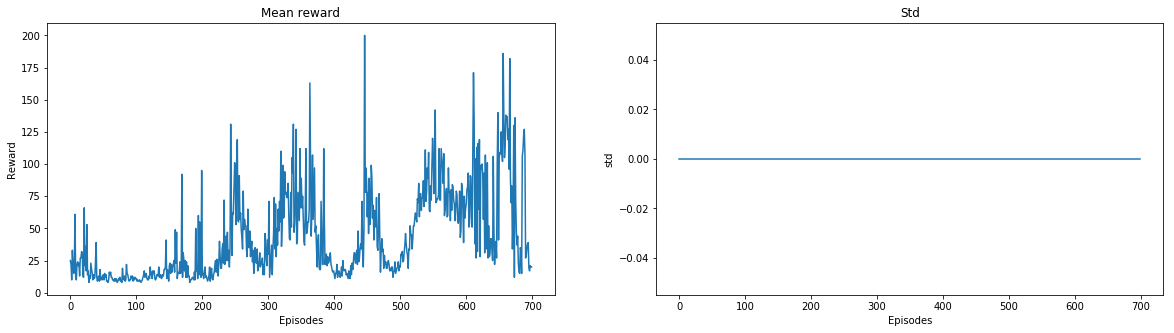

In [43]:
## Attempt 2

class Agent():
    def __init__(self, env=gym.make('CartPole-v0'), model=None):
        self.env = env
        self.episode_durations = []
        self.episode_loss = []
        self.gamma = 0.99
        if model is None:
            self.model = A2CModel(learning_rate=0.02, nb_actions=env.action_space.n)
        else:
            self.model = model
#         self.memory = PolicyGradientMemory()
        self.nb_actions = self.env.action_space.n
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s], dtype=tf.float32)
        action_probability = self.model.P(s).numpy()
        action = np.random.choice(np.arange(self.nb_actions), p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        training_batch_state = []
        training_batch_action = []
        training_batch_Rt = []
        memory = []
        for episode in range(episodes):
#             print("starting episode:", i)
            s = self.env.reset()
            episode_reward = 0
            steps = 0

            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                
                memory_done = done
                # Cartpole specific as the 200 step shouldn't really be done from a calculation perspective
                if self.env.spec.id == "CartPole-v0" and memory_done and episode_reward >= 199:  
                    memory_done = False
#                 self.memory.append(Transition(s, action, s_1, reward, memory_done))
                memory.append((s, action, s_1, reward, memory_done))
                
                s = s_1
                
                episode_reward += reward
                steps += 1
                
                if steps % 5 == 0 or done:
                    Rt = 0
                    # accumulate Rt for samples and add to our training batch
                    for index, mem in enumerate(reversed(memory)):
                        state = mem[0]
                        action = mem[1]
                        state_1 = mem[2]
                        reward = mem[3]
                        mem_done = mem[4]
                        
                        if index == 0: 
                            state_tensor = tf.convert_to_tensor([state_1], dtype=tf.float32)
                            Rt = reward + self.gamma * (1-mem_done) * self.model.V(state_tensor).numpy()[0]
                        else:
                            Rt = reward + self.gamma * Rt
                        
                        training_batch_state.append(state)
                        training_batch_action.append(action)
                        training_batch_Rt.append(Rt)
                    
                    # clear memory
                    memory = []
                
                if done:
                    break
                    
            if (episode+1) % 5 == 0:
#                 print("training batch size:", len(training_batch_state))
                # start training
                s0 = tf.constant(training_batch_state, dtype=tf.float32)
                a = tf.one_hot(training_batch_action, depth=self.nb_actions, dtype=tf.int32)
                r = tf.constant(training_batch_Rt, dtype=tf.float32)

                self.model.train(s0, a, r)


                #start again
                training_batch_state = []
                training_batch_action = []
                training_batch_Rt = []
                    
            self.episode_durations.append(episode_reward)
            
    def run(self, env=gym.make('CartPole-v0')):
        self.env = env
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()


# env=gym.make('LunarLander-v2')
model = A2CModel(learning_rate=0.005, nb_actions=env.action_space.n)

reward_history = RewardHistory()
for i in range(1):
    env=gym.make('CartPole-v0')
    agent = Agent(env)
    agent.train(700)
    reward_history.append(agent.episode_durations)

reward_history.plot()

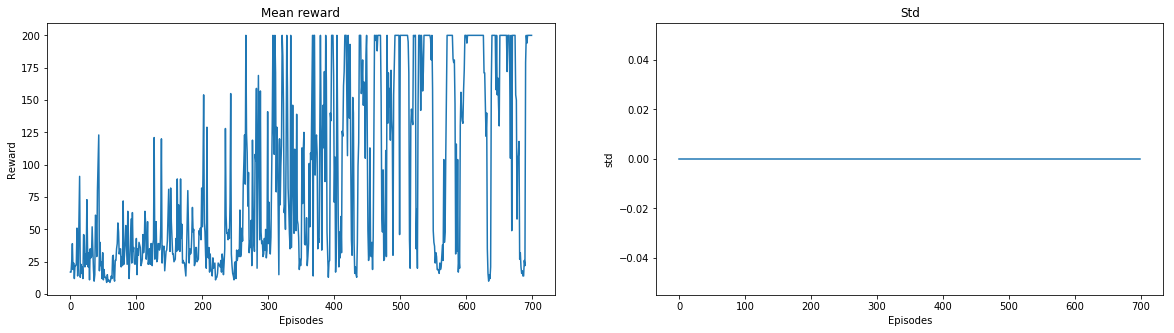

In [124]:
class Agent():
    def __init__(self, env=gym.make('CartPole-v0'), model=None):
        self.env = env
        self.episode_durations = []
        self.episode_loss = []
        self.gamma = 0.99
        if model is None:
            self.model = A2CModel(learning_rate=0.001, nb_actions=env.action_space.n)
        else:
            self.model = model
#         self.memory = PolicyGradientMemory()
        self.nb_actions = self.env.action_space.n
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s], dtype=tf.float32)
        action_probability = self.model.P(s).numpy()
        action = np.random.choice(np.arange(self.nb_actions), p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        training_batch_state = []
        training_batch_action = []
        training_batch_Rt = []
        memory = []
        for i in range(episodes):
#             print("starting episode:", i)
            s = self.env.reset()
            episode_reward = 0
            steps = 0

            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                
                memory_done = done
                # Cartpole specific as the 200 step shouldn't really be done from a calculation perspective
                if self.env.spec.id == "CartPole-v0" and memory_done and episode_reward >= 199:  
                    memory_done = False
#                 self.memory.append(Transition(s, action, s_1, reward, memory_done))
                memory.append((s, action, s_1, reward, memory_done))
                
                s = s_1
                
                episode_reward += reward
                steps += 1
                
                if steps % 5 == 0 or done:
                    Rt = 0
                    # accumulate Rt for samples and add to our training batch
                    for index, mem in enumerate(reversed(memory)):
                        state = mem[0]
                        action = mem[1]
                        state_1 = mem[2]
                        reward = mem[3]
                        mem_done = mem[4]
                        
                        if index == 0: 
                            state_tensor = tf.convert_to_tensor([state_1], dtype=tf.float32)
                            Rt = reward + self.gamma * (1-mem_done) * self.model.V(state_tensor).numpy()[0]
#                             state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
#                             Rt = self.model.V(state_tensor).numpy()[0]
#                             print("final_state_V:", self.model.V(state_tensor))
                        else:
                            Rt = reward + self.gamma * Rt
                        
                        training_batch_state.append(state)
                        training_batch_action.append(action)
                        training_batch_Rt.append(Rt)
                    
                    # clear memory
                    memory = []
#                     print("===========")
#                     for i in range(5):
#                         print("state", training_batch_state[i])
#                         print("action", training_batch_action[i])
#                         print("Rt", training_batch_Rt[i])
                
                
                if len(training_batch_state) >= 5:
                    # start training
                    s0 = tf.constant(training_batch_state, dtype=tf.float32)
                    a = tf.one_hot(training_batch_action, depth=self.nb_actions, dtype=tf.int32)
                    r = tf.constant(training_batch_Rt, dtype=tf.float32)
#                     print("===========")
#                     print(s0)
#                     print(a)
#                     print("Rt", r)

                    self.model.train(s0, a, r)

    
                    #start again
                    training_batch_state = []
                    training_batch_action = []
                    training_batch_Rt = []
#                     break
                
                if done:
                    break
                    
            self.episode_durations.append(episode_reward)
            
    def run(self, env=gym.make('CartPole-v0')):
        self.env = env
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()


# env=gym.make('LunarLander-v2')
model = A2CModel(learning_rate=0.001, nb_actions=env.action_space.n)

reward_history = RewardHistory()
for i in range(1):
    env=gym.make('CartPole-v0')
    agent = Agent(env)
    agent.train(700)
    reward_history.append(agent.episode_durations)

reward_history.plot()